# Class attention applied to a text classification task using BERT

Take two. Hopefully, the preprocessing tools will help to avoid bugs.

In [46]:
import copy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
from transformers import AutoModel, AutoTokenizer
import datasets

import wandb
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import class_attention as cat

%load_ext autoreload
%autoreload 2


def detorch(x):
    return x.detach().cpu().numpy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [2]:
dataset = datasets.load_dataset("Fraser/news-category-dataset")
all_classes = dataset['train'].features['category_num'].names
print(all_classes)

Using custom data configuration default
Reusing dataset news_category (/Users/vladislavlialin/.cache/huggingface/datasets/news_category/default/0.0.0/737b7b6dff469cbba49a6202c9e94f9d39da1fed94e13170cf7ac4b61a75fb9c)


['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY', 'PARENTING', 'HEALTHY LIVING', 'QUEER VOICES', 'FOOD & DRINK', 'BUSINESS', 'COMEDY', 'SPORTS', 'BLACK VOICES', 'HOME & LIVING', 'PARENTS', 'THE WORLDPOST', 'WEDDINGS', 'WOMEN', 'IMPACT', 'DIVORCE', 'CRIME', 'MEDIA', 'WEIRD NEWS', 'GREEN', 'WORLDPOST', 'RELIGION', 'STYLE', 'SCIENCE', 'WORLD NEWS', 'TASTE', 'TECH', 'MONEY', 'ARTS', 'FIFTY', 'GOOD NEWS', 'ARTS & CULTURE', 'ENVIRONMENT', 'COLLEGE', 'LATINO VOICES', 'CULTURE & ARTS', 'EDUCATION']


In [3]:
def sample_dataset(dataset, p):
    """
    Args:
        dataset: datasets.arrow_dataset.Dataset object
        p: float, 0 < p <= 1
    
    Returns:
        datasets.arrow_dataset.Dataset of size len(dataset) * p with random examples from the dataset
        sampled without replacement
    """
    if not 0 < p <= 1:
        raise ValueError(p)

    dataset_len = len(dataset)
    sample_size = int(p * dataset_len)

    ids = random.sample(range(len(dataset)), sample_size)
    
    # indexing actually creates dict with elements of len(ids), not a list
    sampled_dataset_dict = dataset[ids]
    sampled_dataset = datasets.arrow_dataset.Dataset.from_dict(sampled_dataset_dict)
    return sampled_dataset

In [4]:
toy_dataset = sample_dataset(dataset['train'], 0.001)
len(toy_dataset)

1606

In [5]:
toy_dataset[0]['headline']

'Oh, Snap! Slow Mo Guy Puts Tongue In Mouse Trap, Regreths It'

# Text encoder

In [33]:
MODEL = 'distilbert-base-uncased'

text_tokenizer = AutoTokenizer.from_pretrained(MODEL, fast=True)
text_tokenizer.encode_plus(toy_dataset[0]['headline'])

{'input_ids': [101, 2821, 1010, 10245, 999, 4030, 9587, 3124, 8509, 4416, 1999, 8000, 8132, 1010, 9038, 7898, 2009, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [7]:
', '.join(set(toy_dataset['category']))

'ARTS, ENVIRONMENT, ENTERTAINMENT, PARENTING, PARENTS, GREEN, CRIME, SPORTS, LATINO VOICES, SCIENCE, CULTURE & ARTS, POLITICS, STYLE, EDUCATION, TRAVEL, WORLDPOST, GOOD NEWS, HOME & LIVING, HEALTHY LIVING, FIFTY, TECH, THE WORLDPOST, BUSINESS, COLLEGE, MONEY, WEIRD NEWS, MEDIA, WELLNESS, COMEDY, RELIGION, STYLE & BEAUTY, WOMEN, TASTE, WEDDINGS, IMPACT, WORLD NEWS, FOOD & DRINK, ARTS & CULTURE, QUEER VOICES, DIVORCE, BLACK VOICES'

# Label encoder

Just use a tokenizer without UNK

Note that the dataset we use (`Fraser/news-category-dataset`) has some interesting particularities in the class names.

For example, it has classes `STYLE` and `STYLE & BEAUTY` or `WORLD NEWS` and `NEWS`. I.e., some classes contain other classes names in their name.
The classes that have `&` in their name have a similar particularity. Some of the categories does not seem to be distinguishable. E.g., `THE WORLDPOST` and `WORLDPOST` or `ARTS & CULTURE` and `CULTURE & ARTS`.

In [8]:
from collections import defaultdict
from pprint import pprint

_all_classes = set(toy_dataset['category'])
_word2classes = defaultdict(set)

for _class_name in set(_all_classes):
    _similar_classes = []
    for _class_word in _class_name.split(' '):
        for _other_class in _all_classes:
            if _class_name != _other_class and _class_word in _other_class:
                _word2classes[_class_word].add(_other_class)

for _w, _c in _word2classes.items():
    print(f"{_w}\t: {', '.join(_c)}")

ARTS	: ARTS & CULTURE, ARTS, CULTURE & ARTS
VOICES	: QUEER VOICES, LATINO VOICES, BLACK VOICES
CULTURE	: ARTS & CULTURE, CULTURE & ARTS
&	: HOME & LIVING, CULTURE & ARTS, FOOD & DRINK, ARTS & CULTURE, STYLE & BEAUTY
STYLE	: STYLE & BEAUTY, STYLE
WORLDPOST	: THE WORLDPOST, WORLDPOST
NEWS	: GOOD NEWS, WEIRD NEWS, WORLD NEWS
LIVING	: HOME & LIVING, HEALTHY LIVING
WORLD	: THE WORLDPOST, WORLDPOST


In [9]:
label_tokenizer = cat.utils.make_whitespace_tokenizer(toy_dataset['category'], unk_token=None)
label_tokenizer.encode(toy_dataset[0]['category']).ids

[34, 15]

# Dataset object

In [10]:
train_texts = toy_dataset['headline']
train_labels = toy_dataset['category']
dataset = cat.CatDataset(train_texts, text_tokenizer, train_labels, label_tokenizer)

dataset[0]

Preprocessing Dataset:   0%|          | 0/1606 [00:00<?, ?it/s]

(tensor([  101,  2821,  1010, 10245,   999,  4030,  9587,  3124,  8509,  4416,
          1999,  8000,  8132,  1010,  9038,  7898,  2009,   102]),
 tensor([34, 15]))

# Collator

Collator also makes targets. Targets != labels as the labels are strings.

In [11]:
from pprint import pprint

collator = cat.CatCollator(pad_token_id=0)
text_batch, unique_labels, targets = collator([dataset[0], dataset[2]])

print('Text:')
pprint(text_batch)

print('\nUnique labels:')
pprint(unique_labels)

print('Targets:')
pprint(targets)

Text:
tensor([[  101,  2821,  1010, 10245,   999,  4030,  9587,  3124,  8509,  4416,
          1999,  8000,  8132,  1010,  9038,  7898,  2009,   102],
        [  101,  2030, 27844, 10288,  2401,  3475,  1005,  1056,  2740,  3993,
          1025,  4445,  2003,  1996,  3115,  2137,  8738,   102]])

Unique labels:
tensor([[11,  7],
        [34, 15]])
Targets:
tensor([1, 0])


# Dataloader

In [12]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, collate_fn=collator)

In [13]:
next(iter(dataloader))

(tensor([[  101,  2821,  1010,  ...,     0,     0,     0],
         [  101, 20545, 22130,  ...,     0,     0,     0],
         [  101,  2030, 27844,  ...,     0,     0,     0],
         ...,
         [  101,  1037,  7050,  ...,     0,     0,     0],
         [  101,  1996,  4125,  ...,     0,     0,     0],
         [  101,  2775, 28699,  ...,     0,     0,     0]]),
 tensor([[ 1,  0,  0],
         [ 3,  0,  0],
         [ 4,  0,  0],
         [ 5,  0,  0],
         [ 8,  0,  0],
         [10,  0,  0],
         [11,  7,  0],
         [13,  0,  0],
         [14,  0,  0],
         [16,  2, 17],
         [18,  2,  7],
         [19,  0,  0],
         [20,  0,  0],
         [25,  0,  0],
         [26,  0,  0],
         [28,  2, 21],
         [32,  0,  0],
         [33,  0,  0],
         [34, 15,  0],
         [38,  0,  0]]),
 tensor([18,  2,  6,  0, 16,  1,  0, 12,  1,  3,  1,  2,  1, 12, 14,  5, 15,  0,
          5, 10, 12,  8,  0, 11,  9,  0,  1, 17, 19, 13,  7,  4]))

# Model

In [86]:
class ClassAttentionModelEmb(nn.Module):
    def __init__(self, txt_encoder, n_classes, hidden_size):
        super().__init__()

        txt_encoder_h = get_output_dim(txt_encoder)
        self.txt_encoder = txt_encoder
        self.txt_out = nn.Linear(txt_encoder_h, hidden_size)

        self.cls_encoder = nn.Sequential(
            nn.EmbeddingBag(n_classes, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

    def forward(self, text_input, labels_input):
        """
        Compute logits for input (input_dict,) corresponding to the classes (classes_dict)

        Optionally, you can provide additional keys in either input_dict or classes_dict
        Specifically, attention_mask, head_mask and inputs_embeds
        Howerver, one should not provide output_attentions and output_hidden_states

        Args:
            text_input: dict with key input_ids
                input_ids: LongTensor[batch_size, text_seq_len], input to the text network
            labels_input: dict with key input_ids
                input_ids: LongTensor[n_classes, class_seq_len], a list of possible classes, each class described via text
        """
        self._validate_inputs(text_input, labels_input)

        h_x = self.txt_encoder(**text_input)  # some tuple
        h_x = h_x[0]  # FloatTensor[bs, text_seq_len, hidden]
        h_x = h_x[:, 0]  # get CLS token representations, FloatTensor[bs, hidden]

        h_c = self.cls_encoder(labels_input)  # FloatTensor[n_classes, hidden]

        # attention map
        h_x = self.txt_out(h_x)

        logits = h_x @ h_c.T  # [bs, n_classes]
        return logits

    @staticmethod
    def _validate_inputs(text_input_dict, classes_input_dict):
        if not isinstance(text_input_dict, dict):
            raise ValueError('text input should be a dict')
        if not isinstance(classes_input_dict, torch.Tensor):
            raise ValueError('classes input should be a torch.Tensor')

        if classes_input_dict.shape[0] == 1:
            raise RuntimeError(
                'batch dimension of classes tensor is the number of possible classes and cannot be equal to one'
            )

        # check that labels_input does not have duplicated
        unique_classes = torch.unique(classes_input_dict, dim=0)
        if unique_classes.shape[0] != classes_input_dict.shape[0]:
            raise ValueError('labels_input should only contain unique classes')


def get_output_dim(model):
    # config = model.config
    # if isinstance(config, transformers.DistilBertConfig):
    #     return config.hidden_size
    return model.config.hidden_size


In [87]:
text_encoder = AutoModel.from_pretrained(MODEL)

model = ClassAttentionModelEmb(text_encoder, label_tokenizer.get_vocab_size(), hidden_size=32)

In [89]:
x = torch.randint(0, 100, size=[3, 5])
c = torch.randint(0, 100, size=[7, 1])

x_dict = {'input_ids': x}
c_dict = {'input_ids': c}

out = model(text_input=x_dict, labels_input=c)
out.shape

torch.Size([3, 7])

## Train class attention

In [90]:
device = 'cpu'
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters())

<ipython-input-92-7dac58781a41>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(2)):


  0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-92-7dac58781a41>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x, c, y in tqdm(dataloader, total=(len(dataset) // dataloader.batch_size)):


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Accuracy')

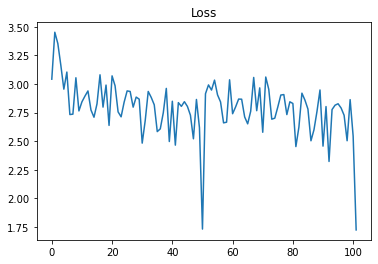

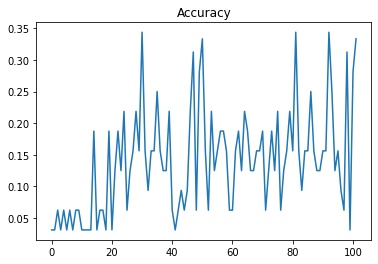

In [92]:
loss_hist = []
acc_hist = []

for _ in tqdm(range(2)):
    for x, c, y in tqdm(dataloader, total=(len(dataset) // dataloader.batch_size)):
        optimizer.zero_grad()

        x = x.to(device)
        c = c.to(device)
        y = y.to(device)

        x_dict = {'input_ids': x}
        logits = model(x_dict, c)

        loss = F.cross_entropy(logits, y)

        _, preds = logits.max(-1)
        acc = torch.sum(preds == y).float() / x.shape[0]

        acc_hist.append(detorch(acc))
        loss_hist.append(detorch(loss))

        loss.backward()
        optimizer.step()


plt.figure()
plt.plot(loss_hist)
plt.title('Loss')

plt.figure()
plt.plot(acc_hist)
plt.title('Accuracy')